# Analysis of CTCF binding sites and SBS17 from Fig 5A and 5B

In [1]:
from collections import defaultdict
import gzip
import json

from intervaltree import IntervalTree
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import pandas as pd
from scipy.signal import savgol_filter
from statsmodels.sandbox.stats.multicomp import multipletests as mlpt

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
def load_ctcf(input_f): 
    """Load CTCF genomic coordinates into an IntervalTree"""

    ctcf_tree = defaultdict(IntervalTree)
    with open(input_f, 'r') as fd:
        next(fd)
        for line in fd:
            chrom, start, end = line.strip().split('\t')[0:3]
            ctcf_tree[chrom].addi(int(start), int(end), f'chr1{chrom}:{start}-{end}')
    return ctcf_tree

In [4]:
def load_hotspots_per_signature(input_f): 
    """Read a table containing hotspots and attribute them to a mutational signature"""

    # Read data per hotspot
    hotspot_sigs = defaultdict(lambda: defaultdict(float))
    signatures = set()
    with gzip.open(input_f, 'rt') as fd: 
        next(fd)
        for line in fd: 
            hotspot, _, _, _, _, signature, prob = line.strip().split()
            hotspot_sigs[hotspot][signature] = prob
            signatures.add(signature)
    # Merge hotspots from equal signature
    signature_hotspots = defaultdict(set)
    for hotspot, data in hotspot_sigs.items(): 
        sorted_sigs = sorted([(s, float(p)) for s, p in data.items()], key=lambda x: x[1], reverse=True)
        if sorted_sigs[0][1] > 0: 
            signature_hotspots[sorted_sigs[0][0]].add(hotspot)
            
    return signature_hotspots

In [5]:
sigs_color = {
 'SBS17a': '#ffbb78ff',
 'SBS17b': '#ff8921ff'
}

In [6]:
data_dir = '../../../data'

In [7]:
def smoothing(data, window_length=101): 
    """Apply smoothing over a list of mutations"""
    
    smooth_data = savgol_filter(data, window_length, 2)
    sum_y = sum(smooth_data)
    
    return [(i/sum_y) for i in smooth_data]

### Load data

Data required for 5A
- Observed list of mutations inside hotspots that are attributed to a signature and overlap 2 Kbp window centered at CTCF binding sites. 
- Observed list of mutations outside hotspots that are attributed to a signature and overlap 2 Kbp window centered at CTCF binding sites. 
- Results of enrichment of hotspot mutations in CTCF binding sites. This includes the expected distribution of mutations across the 2 Kbp window. 

Data required for 5B
- Filtered CTCF binding sites from normal tissues. 
- Hotspots attributed to a signature in the cancer type.

#### Load data for 5A

In [8]:
run_dict = {
 'COADREAD': ['SBS17b', 'SBS17a'],
 'ESOPHA_STOMACH': ['SBS17b', 'SBS17a']
}

In [9]:
# Parameters
smoothing_length = 101
feature_size = 600
window_size = 2000
flank_size = int((window_size - feature_size)  / 2)
flank_size

700

In [10]:
# Load data and get smooting curves to plot
data_to_plot = defaultdict(dict)
lines = []
for ctype, signatures in run_dict.items(): 
    for signature in signatures: 
        print(ctype, signature)
        
        # Load observed INSIDE hotspots
        observed_in_f = f'{data_dir}/ctcf/{ctype}_ctcf_maxprob_length2000.in.txt'
        df = pd.read_csv(observed_in_f, sep='\t', header=0)
        observed_in = []
        df = df.loc[df['SIGNATURE'] == signature].copy()
        for i in range(0, 2000): 
            df_pos = df.loc[df['POS_REL_START'] == i].copy()
            observed_in += [len(df_pos)]
        observed_in_norm = [(i/sum(observed_in)) for i in observed_in]
        # Get smoothing curve to plot
        observed_in = smoothing(observed_in_norm, smoothing_length)
        
        # Load observed OUTSIDE hotspots
        observed_out_f = f'{data_dir}/ctcf/{ctype}_ctcf_maxprob_length2000.out.txt'
        df = pd.read_csv(observed_out_f, sep='\t', header=0)
        observed_out = []
        df = df.loc[df['SIGNATURE'] == signature].copy()
        for i in range(0, 2000): 
            df_pos = df.loc[df['POS_REL_START'] == i].copy()
            observed_out += [len(df_pos)]
        observed_out_norm = [(i/sum(observed_out)) for i in observed_out]
        # Get smoothing curve to plot
        observed_out = smoothing(observed_out_norm, smoothing_length)

        # Load expected
        expected_data_f = f'{data_dir}/ctcf/{ctype}_{signature}_simulations_ctcf_maxprob_length2000.in.json'
        with open(expected_data_f, 'r') as fd: 
            expected_data = json.load(fd)    
        expected_raw = expected_data['expected_muts']
        expected_norm = [(i/sum(expected_raw)) for i in expected_raw]
        # Get smoothing curve to plot
        expected = smoothing(expected_norm, smoothing_length)

        data_to_plot[f'{ctype}_{signature}']['observed_in'] = observed_in
        data_to_plot[f'{ctype}_{signature}']['observed_out'] = observed_out
        data_to_plot[f'{ctype}_{signature}']['expected'] = expected
        data_to_plot[f'{ctype}_{signature}']['observed_fc'] = expected_data['observed_fc']
        data_to_plot[f'{ctype}_{signature}']['pval'] = expected_data['pval']

        lines.append(pd.DataFrame([[f'{ctype}_{signature}', expected_data['observed_fc'], expected_data['pval']]]))
        
table = pd.concat(lines)
table.columns = ['CTYPE_SIG', 'FC', 'PVAL']
# Add multiple testing correction
qvalues = mlpt(table['PVAL'].tolist(), alpha=0.01, method='fdr_bh')[1]
table['QVAL'] = qvalues

COADREAD SBS17b
COADREAD SBS17a
ESOPHA_STOMACH SBS17b
ESOPHA_STOMACH SBS17a


In [11]:
table

,CTYPE_SIG,FC,PVAL,QVAL
0,COADREAD_SBS17b,15.633333,1.110223e-19,1.110223e-19
0,COADREAD_SBS17a,14.333333,1.110223e-19,1.110223e-19
0,ESOPHA_STOMACH_SBS17b,3.211354,1.110223e-19,1.110223e-19
0,ESOPHA_STOMACH_SBS17a,3.820059,1.110223e-19,1.110223e-19


#### Load data for 5B

In [12]:
# COADREAD
ctcf_fil_coadread_f = f'{data_dir}/ctcf/ENCSR857RJQ.CTCF.sigmoid-colon.bed.reformat.txt'
hotspots_coadread_f = f'{data_dir}/hotspots_SBS_prob__COADREAD.txt.gz'

In [13]:
# ESOPHA_STOMACH
ctcf_fil_esopha_stomach_f = f'{data_dir}/ctcf/ENCSR000DTR.CTCF.epithelial_esophagus.bed.reformat.txt'
hotspots_esopha_stomach_f = f'{data_dir}/hotspots_SBS_prob__ESOPHA_STOMACH.txt.gz'

In [14]:
# Intersect hotspots and CTCF sites
results_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

ctype = 'COADREAD'
ctcf_tree_coadread = load_ctcf(ctcf_fil_coadread_f)
signature_hotspots_coadread = load_hotspots_per_signature(hotspots_coadread_f)
for signature in ['SBS17a', 'SBS17b']: 
    for hotspot in signature_hotspots_coadread[signature]:
        chrom, pos, _ = hotspot.split('_')
        results_dict[ctype][signature]['total_hotspots'] += 1
        for interval in ctcf_tree_coadread[chrom][int(pos)]:
            results_dict[ctype][signature]['intersect'] += 1
            
ctype = 'ESOPHA_STOMACH'
ctcf_tree_esopha_stomach = load_ctcf(ctcf_fil_esopha_stomach_f)
signature_hotspots_esopha_stomach = load_hotspots_per_signature(hotspots_esopha_stomach_f)
for signature in ['SBS17a', 'SBS17b']: 
    for hotspot in signature_hotspots_esopha_stomach[signature]:
        chrom, pos, _ = hotspot.split('_')
        results_dict[ctype][signature]['total_hotspots'] += 1
        for interval in ctcf_tree_esopha_stomach[chrom][int(pos)]:
            results_dict[ctype][signature]['intersect'] += 1

## Panel 5A

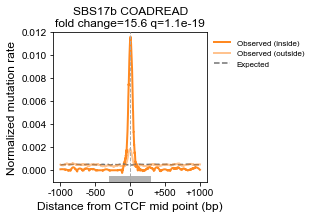

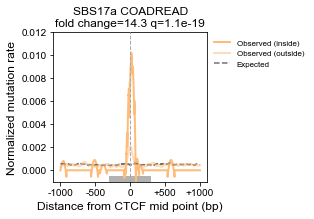

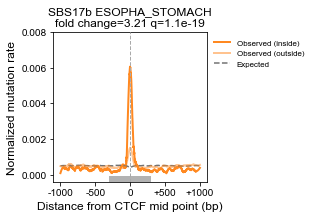

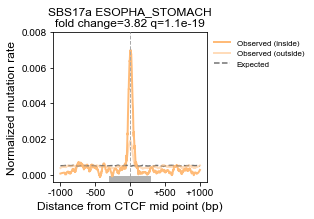

In [15]:
for ctype, signature in [
    ('COADREAD', 'SBS17b'), ('COADREAD', 'SBS17a'), 
    ('ESOPHA_STOMACH', 'SBS17b'), ('ESOPHA_STOMACH', 'SBS17a')
]: 
    
    observed_in = data_to_plot[f'{ctype}_{signature}']['observed_in']
    observed_out = data_to_plot[f'{ctype}_{signature}']['observed_out']
    expected = data_to_plot[f'{ctype}_{signature}']['expected']
    fold_change = data_to_plot[f'{ctype}_{signature}']['observed_fc']
    qval = table.loc[table['CTYPE_SIG'] == f'{ctype}_{signature}']['QVAL'].iloc[0]

    fig = plt.figure(figsize=(2.75, 2.75))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.set_ylabel('Normalized mutation rate', fontsize=12)
    ax.set_xlabel('Distance from CTCF mid point (bp)', fontsize=12)
    plt.title(f'{signature} {ctype}\nfold change={fold_change:0.3} q={qval:0.1e}', fontsize=12)

    ax.plot(list(range(0, len(observed_in))), observed_in, '-', lw=2, color=sigs_color[signature], label='Observed (inside)', alpha=1, zorder=1)
    ax.plot(list(range(0, len(observed_out))), observed_out, '-', lw=2, color=sigs_color[signature], label='Observed (outside)', alpha=0.5, zorder=3)
    ax.plot(list(range(0, len(expected))), expected, '--', lw=1.5, color='#727272ff', label='Expected', alpha=1, zorder=2)

    ax.set_xticks([0, 500, 1000, 1500, 2000])
    ax.set_xticklabels(['-1000', '-500', '0', '+500', '+1000'], fontsize=10)
    ax.axvline(x=1000, color='darkgrey', linestyle='--', linewidth=1, zorder=10)
    ax.legend(bbox_to_anchor=(1, 1), fontsize=8).get_frame().set_edgecolor('w')
    ax.set_ylim(-0.001, 0.012)

    # Create CTCF site rectangle
    if ctype == 'COADREAD' and signature == 'SBS17a': 
        rect = patches.Rectangle((flank_size, -0.0005), feature_size, -0.0005, linewidth=0, facecolor='#b2b2b2ff')
        ax.add_patch(rect)
        ax.set_ylim(-0.001, 0.012)
    if ctype == 'COADREAD' and signature == 'SBS17b': 
        rect = patches.Rectangle((flank_size, -0.0005), feature_size, -0.0005, linewidth=0, facecolor='#b2b2b2ff')
        ax.add_patch(rect)
        ax.set_ylim(-0.001, 0.012)  
    if ctype == 'ESOPHA_STOMACH' and signature == 'SBS17a': 
        rect = patches.Rectangle((flank_size, -0.0004), feature_size, 0.0003, linewidth=0, facecolor='#b2b2b2ff')
        ax.add_patch(rect)
        ax.set_ylim(-0.0004, 0.008)
    if ctype == 'ESOPHA_STOMACH' and signature == 'SBS17b': 
        rect = patches.Rectangle((flank_size, -0.0004), feature_size, 0.0003, linewidth=0, facecolor='#b2b2b2ff')
        ax.add_patch(rect)
        ax.set_ylim(-0.0004, 0.008)

    for extension in ['png']: 
        output = f'./fig_5A_{ctype}_{signature}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 5B

In [16]:
def plot_fraction_hotspots_CTCF(ctype, signature, intersect, total): 

    fig = plt.figure(figsize=(1.4, 0.2))
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.text(0, 1.5, f'CTCF overlap ({round(100*intersect/total, 2)}%)', fontsize=5, color='black')
    ax.set_xlabel(f'{signature} {ctype} hotspots (%)', fontsize=6)

    plt.barh(y=1, left=0, width=100*intersect/total, align='center', alpha=1, color=sigs_color[signature], height=0.8)
    plt.barh(y=1, left=(100*intersect/total), width=(100-(100*intersect/total)), align='center', alpha=1, color='#dedddaff',  height=0.8)

    ax.set_yticklabels([], fontsize=5, rotation=0)
    ax.tick_params(axis='y', which='major', pad=2)
    ax.set_xlim(-1, 100)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels([0, 25, 50, 75, 100], fontsize=5)

    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0)

    for extension in ['png']: 
        output = f'./fig_5B_{ctype}_{signature}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

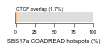

In [17]:
signature = 'SBS17a'
ctype = 'COADREAD'
intersect = results_dict[ctype][signature]['intersect']
total = results_dict[ctype][signature]['total_hotspots']
plot_fraction_hotspots_CTCF(ctype, signature, intersect, total)

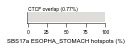

In [18]:
signature = 'SBS17a'
ctype = 'ESOPHA_STOMACH'
intersect = results_dict[ctype][signature]['intersect']
total = results_dict[ctype][signature]['total_hotspots']
plot_fraction_hotspots_CTCF(ctype, signature, intersect, total)

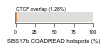

In [19]:
signature = 'SBS17b'
ctype = 'COADREAD'
intersect = results_dict[ctype][signature]['intersect']
total = results_dict[ctype][signature]['total_hotspots']
plot_fraction_hotspots_CTCF(ctype, signature, intersect, total)

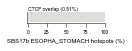

In [20]:
signature = 'SBS17b'
ctype = 'ESOPHA_STOMACH'
intersect = results_dict[ctype][signature]['intersect']
total = results_dict[ctype][signature]['total_hotspots']
plot_fraction_hotspots_CTCF(ctype, signature, intersect, total)